In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import math
import os, sys
from tqdm import tqdm
import random

from denoising_diffusion_pytorch import GaussianDiffusion
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import SinusoidalPosEmb

C:\Users\lukov\miniconda3\envs\dd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from script_toy_diffusion import OneDDataset, OneDModel, DebugGaussianDiffusion, unnormalize_to_zero_to_one

In [3]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = [10, 7]

In [4]:
def visualize_process(imgs, bins=200, range=(-0.5, 1.5)):
    data = []
    for img in imgs:
        img = img[:,0,0,0].cpu().numpy()
        hist, _ = np.histogram(img, bins, range=range)
        hist = hist / np.max(hist)
        data.append(hist)
        
    data = np.array(data)
    data = data.T
        
    fig2 = plt.figure(figsize = (15,10)) # create a 5 x 5 figure 
    ax3 = fig2.add_subplot(111)
    ax3.imshow(data, interpolation='none')
    ax3.set_title('larger figure')

    plt.show()

    return data

In [5]:
m = OneDModel(64)
x = torch.randn((5, 1, 1, 1))
t = torch.rand((5,))
print(x, t)

# y = m(x, t)
# print(y)
timesteps = 1000

diffusion = DebugGaussianDiffusion(model=m, image_size=1, timesteps=timesteps, loss_type="l2", objective="pred_x0")

ds = OneDDataset()
dl = torch.utils.data.DataLoader(ds, batch_size=256)

print(len(ds))
samples = [x[0, 0, 0].item() for x in ds]
print(samples[0:100])
# _ = plt.hist(samples, density=True, bins=100)
# plt.show()

step = 0
epochs = 2000

device = torch.device("cuda:0")
diffusion.to(device)
done = False

optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-3, betas=(0.9, 0.99))


tensor([[[[ 0.5029]]],


        [[[-0.1355]]],


        [[[ 1.1081]]],


        [[[ 1.7258]]],


        [[[ 0.4479]]]]) tensor([0.1130, 0.8607, 0.7426, 0.6247, 0.7498])
4000
[0.1995648592710495, 0.2018188238143921, 0.19936533272266388, 0.9996891617774963, 0.7999789118766785, 0.8026058673858643, 0.19771938025951385, 0.9994886517524719, 0.1996431052684784, -5.24734532518778e-05, 0.1988985538482666, 0.20227302610874176, 1.0001320838928223, 4.678955519921146e-05, 0.999811589717865, 0.20110347867012024, 0.7990212440490723, 0.19947673380374908, 0.7993609309196472, 0.9989842176437378, 0.2018415480852127, -0.0021440028212964535, 0.20046669244766235, 0.7999101877212524, 0.9995697736740112, 1.0016767978668213, -0.00022214738419279456, 1.0009804964065552, 1.0006760358810425, -0.00024785156711004674, 0.20002645254135132, 0.7999112606048584, 0.0001226179301738739, 0.8017874360084534, 1.0005031824111938, 1.0016075372695923, 0.7983546853065491, -0.0009389011538587511, 1.0000312328338623, -0.00086

In [6]:
done = False
step = 0
with tqdm(initial=step, total=epochs * len(dl)) as pbar:
    while not done:
        losses = []
        for batch in dl:
            batch = batch.to(device)

            total_loss = 0.

            loss = diffusion(batch)
            loss.backward()
            losses.append(loss.cpu().item())

            pbar.set_description(f'loss: {np.mean(losses):.4f}')

            optimizer.step()
            optimizer.zero_grad()

            step += 1
            pbar.update(1)

            if step >= epochs * len(dl):
                done = True
        if step % (len(dl) * 50) == 0:
            print("")

print("done training")

loss: 0.3519:   3%|█▌                                                             | 824/32000 [00:07<03:39, 142.26it/s]

loss: 0.3507:   5%|███▏                                                          | 1625/32000 [00:13<03:39, 138.29it/s]

loss: 0.3602:   8%|████▋                                                         | 2425/32000 [00:19<03:22, 146.31it/s]

loss: 0.3537:  10%|██████▎                                                       | 3226/32000 [00:24<03:16, 146.15it/s]

loss: 0.3578:  13%|███████▊                                                      | 4026/32000 [00:30<03:10, 146.98it/s]

loss: 0.3571:  15%|█████████▎                                                    | 4828/32000 [00:35<03:12, 141.34it/s]

loss: 0.3645:  18%|██████████▉                                                   | 5628/32000 [00:41<02:53, 152.02it/s]

loss: 0.3598:  20%|████████████▍                                                 | 6424/32000 [00:47<03:00, 141.94it/s]

loss: 0.3562:  23%|██████████████                                                | 7226/32000 [00:52<02:52, 143.58it/s]

loss: 0.3587:  25%|███████████████▌                                              | 8027/32000 [00:58<02:33, 156.39it/s]

loss: 0.3789:  28%|█████████████████                                             | 8824/32000 [01:03<02:42, 142.64it/s]

loss: 0.3684:  30%|██████████████████▋                                           | 9627/32000 [01:09<02:24, 154.41it/s]

loss: 0.3695:  33%|███████████████████▊                                         | 10425/32000 [01:14<02:30, 143.19it/s]

loss: 0.3714:  35%|█████████████████████▍                                       | 11225/32000 [01:20<02:25, 143.20it/s]

loss: 0.3652:  38%|██████████████████████▉                                      | 12024/32000 [01:26<02:21, 141.09it/s]

loss: 0.3654:  40%|████████████████████████▍                                    | 12826/32000 [01:31<02:13, 143.41it/s]

loss: 0.3527:  43%|█████████████████████████▉                                   | 13625/32000 [01:37<02:08, 142.98it/s]

loss: 0.3669:  45%|███████████████████████████▍                                 | 14425/32000 [01:42<02:02, 143.17it/s]

loss: 0.3592:  48%|█████████████████████████████                                | 15225/32000 [01:48<01:57, 143.21it/s]

loss: 0.3638:  50%|██████████████████████████████▌                              | 16024/32000 [01:53<01:51, 143.39it/s]

loss: 0.3748:  53%|████████████████████████████████                             | 16827/32000 [01:59<01:40, 151.22it/s]

loss: 0.3645:  55%|█████████████████████████████████▌                           | 17626/32000 [02:05<01:34, 152.06it/s]

loss: 0.3517:  58%|███████████████████████████████████                          | 18423/32000 [02:10<01:39, 136.41it/s]

loss: 0.3622:  60%|████████████████████████████████████▋                        | 19222/32000 [02:16<01:32, 137.46it/s]

loss: 0.3551:  63%|██████████████████████████████████████▏                      | 20029/32000 [02:22<01:21, 146.84it/s]

loss: 0.3749:  65%|███████████████████████████████████████▋                     | 20826/32000 [02:28<01:15, 147.12it/s]

loss: 0.3430:  68%|█████████████████████████████████████████▏                   | 21628/32000 [02:33<01:07, 154.22it/s]

loss: 0.3715:  70%|██████████████████████████████████████████▋                  | 22423/32000 [02:39<01:09, 137.63it/s]

loss: 0.3537:  73%|████████████████████████████████████████████▎                | 23226/32000 [02:44<00:57, 152.25it/s]

loss: 0.3800:  75%|█████████████████████████████████████████████▊               | 24024/32000 [02:50<00:58, 136.10it/s]

loss: 0.3694:  78%|███████████████████████████████████████████████▎             | 24825/32000 [02:55<00:49, 145.15it/s]

loss: 0.3608:  80%|████████████████████████████████████████████████▊            | 25627/32000 [03:01<00:42, 149.85it/s]

loss: 0.3724:  83%|██████████████████████████████████████████████████▍          | 26428/32000 [03:06<00:37, 150.17it/s]

loss: 0.3554:  85%|███████████████████████████████████████████████████▉         | 27226/32000 [03:12<00:32, 146.47it/s]

loss: 0.3550:  88%|█████████████████████████████████████████████████████▍       | 28026/32000 [03:17<00:28, 141.79it/s]

loss: 0.3502:  90%|██████████████████████████████████████████████████████▉      | 28829/32000 [03:23<00:20, 156.68it/s]

loss: 0.3608:  93%|████████████████████████████████████████████████████████▍    | 29627/32000 [03:28<00:16, 145.26it/s]

loss: 0.3686:  95%|█████████████████████████████████████████████████████████▉   | 30425/32000 [03:33<00:10, 144.80it/s]

loss: 0.3731:  98%|███████████████████████████████████████████████████████████▌ | 31224/32000 [03:39<00:05, 146.45it/s]

loss: 0.3610: 100%|█████████████████████████████████████████████████████████████| 32000/32000 [03:44<00:00, 142.49it/s]


done training


sampling loop time step: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1088.77it/s]


torch.Size([10000, 1, 1, 1])


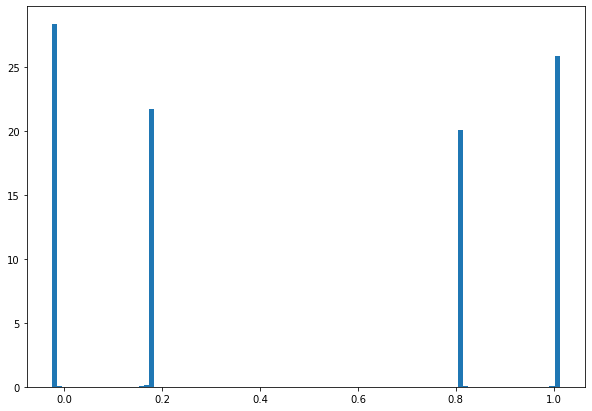

In [7]:
diffusion.is_ddim_sampling = False
diffusion.sampling_timesteps = timesteps
sampled_images, imgacc, x0acc = diffusion.sample(batch_size=10000)
print(sampled_images.shape)  # (4, 3, 128, 128)
sampled_images = sampled_images[:, 0, 0, 0]
#print(sampled_images)
_ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=100)
plt.show()

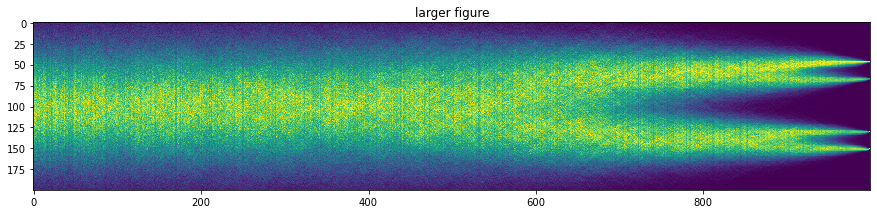

In [8]:
_ = visualize_process(imgacc)

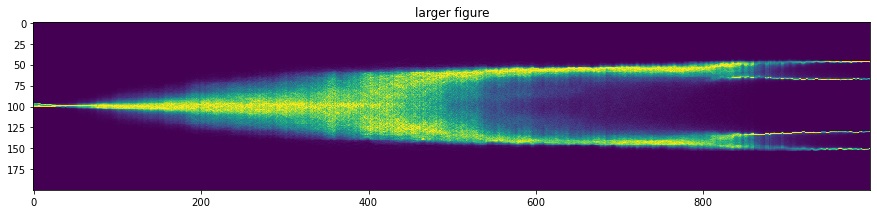

In [9]:
_ = visualize_process(x0acc)

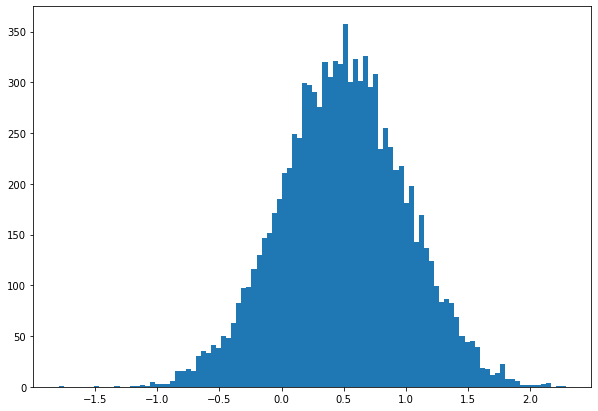

In [10]:
_ = plt.hist(imgacc[2][:, 0,0,0].cpu().numpy(), bins=100)

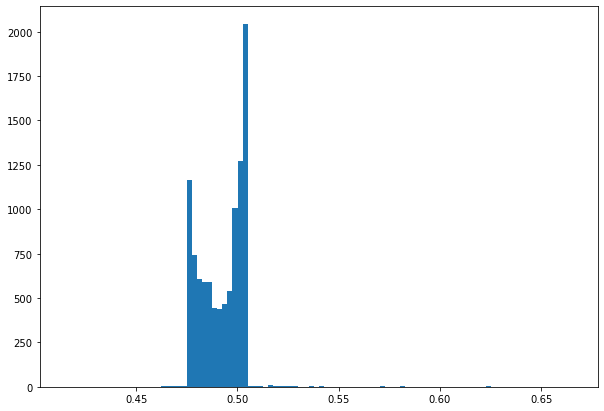

In [11]:
_ = plt.hist(x0acc[0][:, 0,0,0].cpu().numpy(), bins=100)

ddim


sampling loop time step: 100%|█████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1300.84it/s]


torch.Size([10000, 1, 1, 1])


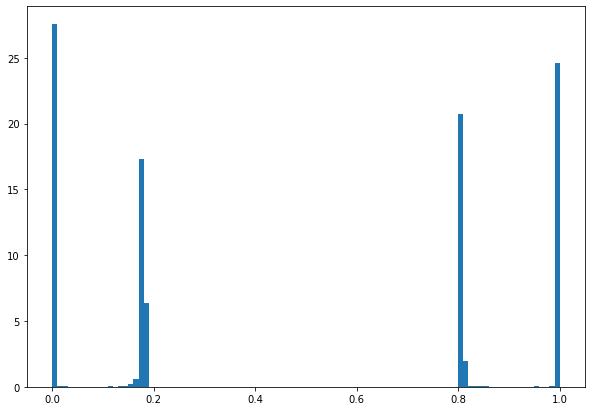

In [12]:
diffusion.is_ddim_sampling = True
diffusion.ddim_sampling_eta = 0
diffusion.sampling_timesteps = timesteps // 2
sampled_images, imgacc, x0acc = diffusion.sample(batch_size=10000)
print(sampled_images.shape)  # (4, 3, 128, 128)
sampled_images = sampled_images[:, 0, 0, 0]
#print(sampled_images)
_ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=100)
plt.show()

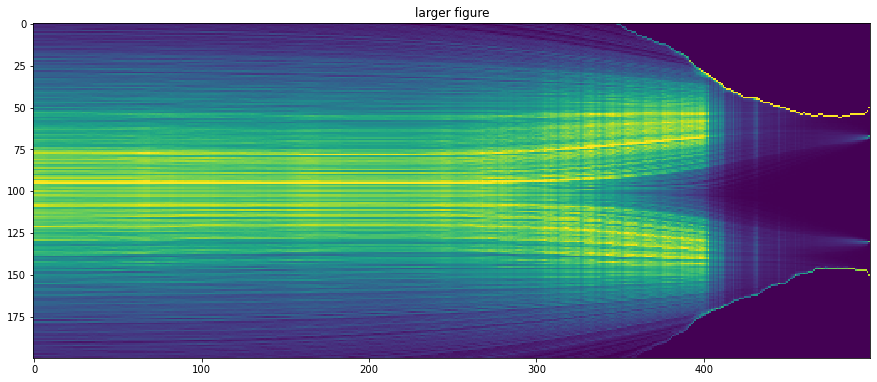

In [13]:
_ = visualize_process(imgacc)

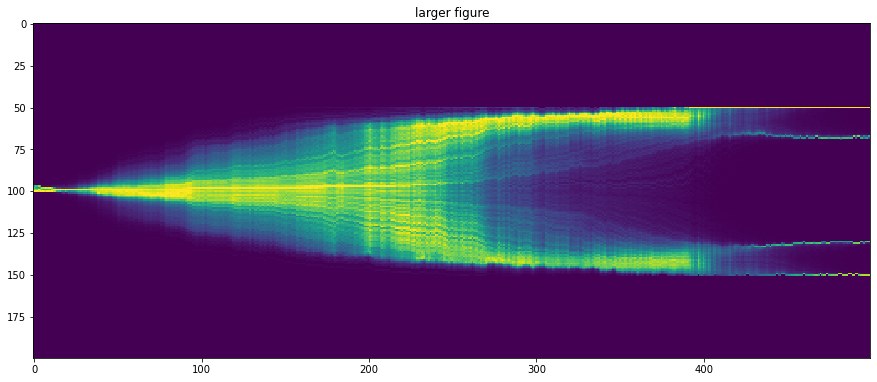

In [14]:
_ = visualize_process(x0acc)

ddim


sampling loop time step: 100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1281.76it/s]

torch.Size([10000, 1, 1, 1])


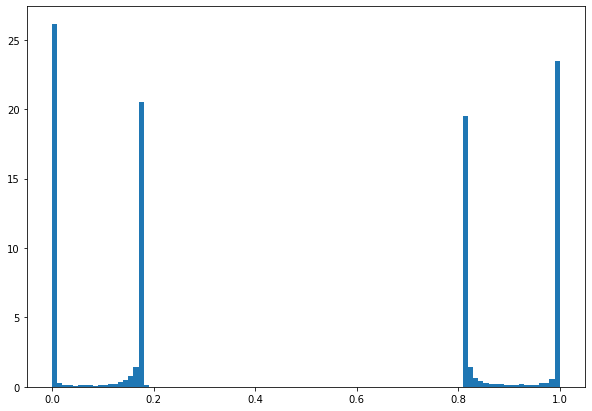

In [15]:
diffusion.is_ddim_sampling = True
diffusion.ddim_sampling_eta = 0
diffusion.sampling_timesteps = 50
sampled_images, imgacc, x0acc = diffusion.sample(batch_size=10000)
print(sampled_images.shape)  # (4, 3, 128, 128)
sampled_images = sampled_images[:, 0, 0, 0]
#print(sampled_images)
_ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=100)
plt.show()

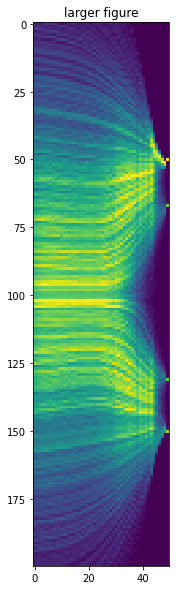

In [16]:
_ = visualize_process(imgacc)

In [17]:
# TODO: compare DDIM trajectories for the same starting points between normal number of steps and fewer number of steps

In [18]:
def show_trajectories(diffusion, faststeps=10, numtraj=5, range=(-1, 1)):
    x_T = np.linspace(range[0], range[1], numtraj)
    diffusion.is_ddim_sampling = True
    diffusion.ddim_sampling_eta = 0
    diffusion.sampling_timesteps = timesteps
    
    sampled_images, times, imgacc, x0acc = diffusion.ddim_sample((numtraj, 1,1,1), 
                                                                 x_T=torch.tensor(x_T)[:, None, None, None].to(torch.float)
                                                                     .to(diffusion.betas.device))
    
    print(len(times), len(imgacc))
    
    trajs = [[x_t_i] for x_t_i in unnormalize_to_zero_to_one(x_T)]
    
    for img in imgacc:
        img = img[:,0,0,0].cpu().numpy()
        for img_i, traj in zip(img, trajs):
            traj.append(img_i)
        
    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(111)
    for traj in trajs:
        ax.plot(times, traj, "blue")
    ax.set_title('trajectories')
    
    diffusion.sampling_timesteps = faststeps
    
    sampled_images, times, imgacc, x0acc = diffusion.ddim_sample((numtraj, 1,1,1), 
                                                                 x_T=torch.tensor(x_T)[:, None, None, None].to(torch.float)
                                                                     .to(diffusion.betas.device))
    
    print(len(times), len(imgacc))
    
    trajs = [[x_t_i] for x_t_i in unnormalize_to_zero_to_one(x_T)]
    
    for img in imgacc:
        img = img[:,0,0,0].cpu().numpy()
        for img_i, traj in zip(img, trajs):
            traj.append(img_i)
        
    for traj in trajs:
        ax.plot(times, traj, "ro-")
    ax.set_title('trajectories')

    plt.show()

    return trajs

ddim


sampling loop time step: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1362.60it/s]


1001 1000
ddim


sampling loop time step: 100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1351.04it/s]


51 50


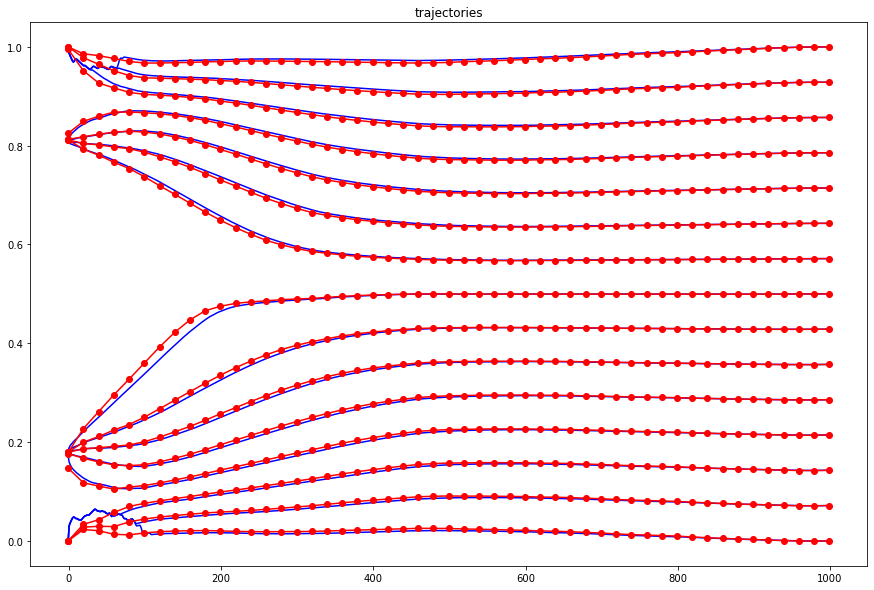

In [19]:
_ = show_trajectories(diffusion, faststeps=50, numtraj=15)

ddim


sampling loop time step: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1380.90it/s]


1001 1000
ddim


sampling loop time step: 100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1350.99it/s]


51 50


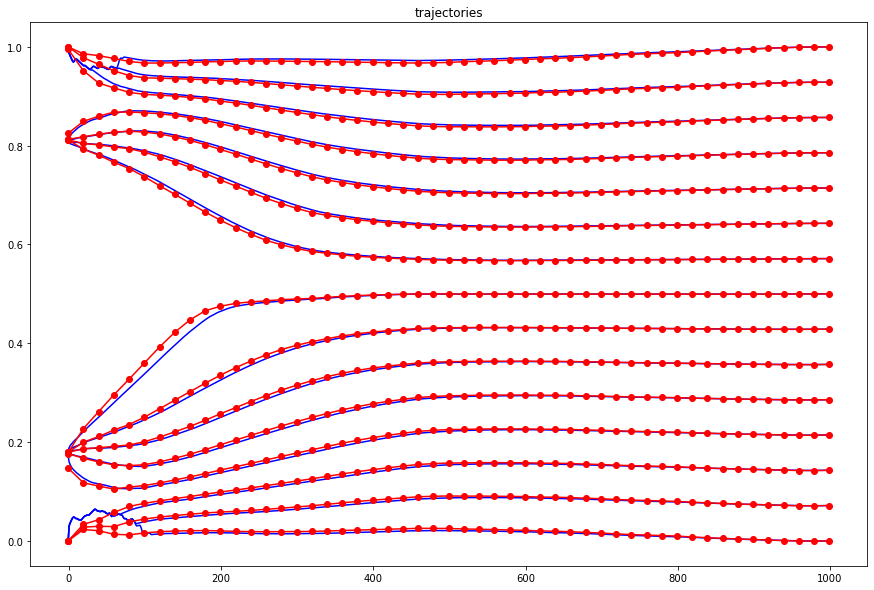

In [24]:
_ = show_trajectories(diffusion, faststeps=50, numtraj=15)